In [1]:
import sys
sys.path.append("..")  # Adds /lab3-1/ to sys.path for ridge_utils

import gensim
import os
import pickle 
import numpy as np
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from preprocessing import downsample_word_vectors, make_delayed

# Set up path
data_path = "/ocean/projects/mth240012p/shared/data"
raw_text_path = os.path.join(data_path, "raw_text.pkl")

# ----- Data split -----

# Load raw text
with open(raw_text_path, "rb") as f:
    raw_text = pickle.load(f)

# Train/test split
story_names = list(raw_text.keys())
train_stories, test_stories = train_test_split(story_names, test_size=0.2, random_state=42)



In [2]:
# ----- 1. Generate GloVe embeddings -----

# Load pre-trained GloVe (glove-wiki-gigaword-300, 300D)
glove_model = api.load("glove-wiki-gigaword-300")

# Convert for all stories
word_vectors = {}  # dictionary: story -> (T, 300)
for story in story_names:
    words = raw_text[story].data
    vectors = []
    for word in words:
        if word in glove_model:
            vectors.append(glove_model[word])
        else:
            vectors.append(np.zeros(300))  # Zero vector for out-of-vocabulary words
    word_vectors[story] = np.vstack(vectors)
    print(f"{story}: GloVe shape = {word_vectors[story].shape}")  # Expected shape: (T, 300)



sweetaspie: GloVe shape = (697, 300)
thatthingonmyarm: GloVe shape = (2073, 300)
tildeath: GloVe shape = (2297, 300)
indianapolis: GloVe shape = (1554, 300)
lawsthatchokecreativity: GloVe shape = (2084, 300)
golfclubbing: GloVe shape = (1211, 300)
jugglingandjesus: GloVe shape = (887, 300)
shoppinginchina: GloVe shape = (1731, 300)
cocoonoflove: GloVe shape = (1984, 300)
hangtime: GloVe shape = (1927, 300)
beneaththemushroomcloud: GloVe shape = (1916, 300)
dialogue4: GloVe shape = (1692, 300)
thepostmanalwayscalls: GloVe shape = (2220, 300)
stumblinginthedark: GloVe shape = (2681, 300)
kiksuya: GloVe shape = (1699, 300)
haveyoumethimyet: GloVe shape = (2985, 300)
theinterview: GloVe shape = (1079, 300)
againstthewind: GloVe shape = (838, 300)
tetris: GloVe shape = (1350, 300)
canplanetearthfeedtenbillionpeoplepart2: GloVe shape = (2532, 300)
alternateithicatom: GloVe shape = (2174, 300)
goldiethegoldfish: GloVe shape = (1680, 300)
seedpotatoesofleningrad: GloVe shape = (1376, 300)
onap

In [3]:
# ----- 2. Downsample and trim -----

wordseqs = raw_text
downsampled_glove = downsample_word_vectors(train_stories + test_stories, word_vectors, wordseqs)

# Trim first 5 seconds (5 time points) and last 10 seconds (10 time points)
# Assuming 1 time point = 1 second for simplicity (adjust based on TR if different)
X_glove_trimmed = {}
for story in downsampled_glove:
    X_glove_trimmed[story] = downsampled_glove[story][5:-10, :]
    print(f"Trimmed GloVe shape for {story}:", X_glove_trimmed[story].shape)

Trimmed GloVe shape for theadvancedbeginner: (318, 300)
Trimmed GloVe shape for superheroesjustforeachother: (325, 300)
Trimmed GloVe shape for seedpotatoesofleningrad: (281, 300)
Trimmed GloVe shape for mayorofthefreaks: (475, 300)
Trimmed GloVe shape for adollshouse: (241, 300)
Trimmed GloVe shape for cautioneating: (279, 300)
Trimmed GloVe shape for haveyoumethimyet: (496, 300)
Trimmed GloVe shape for ifthishaircouldtalk: (249, 300)
Trimmed GloVe shape for myfathershands: (170, 300)
Trimmed GloVe shape for thecurse: (407, 300)
Trimmed GloVe shape for hangtime: (324, 300)
Trimmed GloVe shape for breakingupintheageofgoogle: (521, 300)
Trimmed GloVe shape for theclosetthatateeverything: (314, 300)
Trimmed GloVe shape for leavingbaghdad: (327, 300)
Trimmed GloVe shape for myfirstdaywiththeyankees: (358, 300)
Trimmed GloVe shape for itsabox: (355, 300)
Trimmed GloVe shape for golfclubbing: (201, 300)
Trimmed GloVe shape for odetostepfather: (404, 300)
Trimmed GloVe shape for gpsformylost

In [4]:
from preprocessing import make_delayed

# Create lagged features for each story
X_glove_lagged = {}
for story in X_glove_trimmed:
    X_glove_lagged[story] = make_delayed(X_glove_trimmed[story], delays=range(1, 5))
    print(f"Lagged GloVe shape for {story}:", X_glove_lagged[story].shape)

Lagged GloVe shape for theadvancedbeginner: (318, 1200)
Lagged GloVe shape for superheroesjustforeachother: (325, 1200)
Lagged GloVe shape for seedpotatoesofleningrad: (281, 1200)
Lagged GloVe shape for mayorofthefreaks: (475, 1200)
Lagged GloVe shape for adollshouse: (241, 1200)
Lagged GloVe shape for cautioneating: (279, 1200)
Lagged GloVe shape for haveyoumethimyet: (496, 1200)
Lagged GloVe shape for ifthishaircouldtalk: (249, 1200)
Lagged GloVe shape for myfathershands: (170, 1200)
Lagged GloVe shape for thecurse: (407, 1200)
Lagged GloVe shape for hangtime: (324, 1200)
Lagged GloVe shape for breakingupintheageofgoogle: (521, 1200)
Lagged GloVe shape for theclosetthatateeverything: (314, 1200)
Lagged GloVe shape for leavingbaghdad: (327, 1200)
Lagged GloVe shape for myfirstdaywiththeyankees: (358, 1200)
Lagged GloVe shape for itsabox: (355, 1200)
Lagged GloVe shape for golfclubbing: (201, 1200)
Lagged GloVe shape for odetostepfather: (404, 1200)
Lagged GloVe shape for gpsformylosti

In [5]:
# ----- 4. Check -----
# Check if all train and test stories are in X_glove_lagged
missing_train_glove = [story for story in train_stories if story not in X_glove_lagged]
missing_test_glove = [story for story in test_stories if story not in X_glove_lagged]

print(f"Missing in X_glove_lagged (train): {missing_train_glove}")
print(f"Missing in X_glove_lagged (test): {missing_test_glove}")

Missing in X_glove_lagged (train): []
Missing in X_glove_lagged (test): []


# Part 2 Modeling

In [6]:
import numpy as np
from joblib import dump
from sklearn.model_selection import cross_val_score

subject2_path = os.path.join(data_path, "subject2")
X_train = []
Y_train = []

for story in train_stories:
    if story in X_glove_lagged:
        bold_path = os.path.join(subject2_path, f"{story}.npy")
        if os.path.exists(bold_path):
            Y = np.load(bold_path)
            X = X_glove_lagged[story]
            min_len = min(X.shape[0], Y.shape[0])
            X_train.append(X[:min_len])
            Y_train.append(Y[:min_len])
        else:
            print(f"Missing Y file for: {story}")

X_train = np.vstack(X_train)
Y_train = np.vstack(Y_train)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)

Missing Y file for: myfirstdaywiththeyankees
Missing Y file for: dialogue6
Missing Y file for: dialogue5
Missing Y file for: dialogue3
Missing Y file for: dialogue2
X_train: (28644, 1200)
Y_train: (28644, 94251)


In [7]:
# ----- Fit Ridge regression -----
from sklearn.linear_model import Ridge
from joblib import dump

# Clean NaNs
mask = ~np.isnan(Y_train).any(axis=1)
X_train_clean = X_train[mask]
Y_train_clean = Y_train[mask]

Y_train_small = Y_train_clean[:, :]

# ----- Cross Validation -----
ridge = Ridge(alpha=100.0)
cv_scores = cross_val_score(ridge, X_train_clean, Y_train_small, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores):.4f}")

# Fit Ridge
ridge = Ridge(alpha=100.0)
ridge.fit(X_train_clean, Y_train_small)

Cross-validation scores: [-1.04592411 -1.04599519 -0.99359865 -1.04592065 -1.0111593 ]
Mean cross-validation score: -1.0285


Ridge(alpha=100.0)

In [ ]:
# ----- Evaluate on test set -----
X_test = []
Y_test = []

for story in test_stories:
    if story in X_glove_lagged:
        bold_path = os.path.join(subject2_path, f"{story}.npy")
        if os.path.exists(bold_path):
            Y = np.load(bold_path)
            X = X_glove_lagged[story]
            min_len = min(X.shape[0], Y.shape[0])
            X_test.append(X[:min_len])
            Y_test.append(Y[:min_len])
        else:
            print(f"Missing Y file for: {story}")

X_test = np.vstack(X_test)
Y_test = np.vstack(Y_test)

In [12]:
from scipy.stats import pearsonr

# Clean test NaNs
mask = ~np.isnan(Y_test).any(axis=1)
X_test_clean = X_test[mask]
Y_test_clean = Y_test[mask]

Y_test_small = Y_test_clean[:, :]

# Predict
Y_pred = ridge.predict(X_test_clean)

# Compute CCs
def compute_voxel_ccs(y_true, y_pred):
    ccs = []
    for i in range(y_true.shape[1]):
        try:
            cc, _ = pearsonr(y_true[:, i], y_pred[:, i])
        except:
            cc = np.nan
        ccs.append(cc)
    return np.array(ccs)

ccs_GloVe = compute_voxel_ccs(Y_test_small, Y_pred)

print(f"Mean CC: {np.mean(ccs_GloVe):.4f}")
print(f"Median CC: {np.median(ccs_GloVe):.4f}")
print(f"Top 1% CC: {np.percentile(ccs_GloVe, 99):.4f}")
print(f"Top 5% CC: {np.percentile(ccs_GloVe, 95):.4f}")

Mean CC: 0.0049
Median CC: 0.0044
Top 1% CC: 0.0441
Top 5% CC: 0.0302


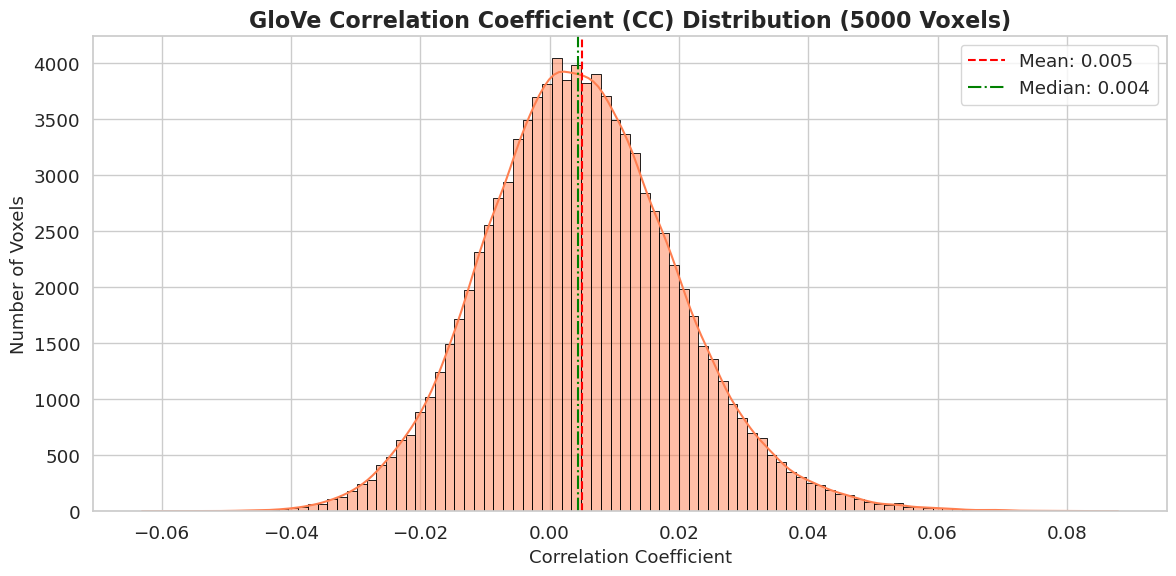

Plot saved to: ../results/cc_distribution_GloVe_subject2_5000vox.png


In [13]:
# ----- Visualization -----
# ----- Histogram -----

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 6))

sns.histplot(ccs_GloVe[~np.isnan(ccs_GloVe)], bins=100, kde=True, color="#FF7F50", edgecolor="black", stat="count")
plt.axvline(np.mean(ccs_GloVe), color='red', linestyle='--', label=f"Mean: {np.mean(ccs_GloVe):.3f}")
plt.axvline(np.median(ccs_GloVe), color='green', linestyle='-.', label=f"Median: {np.median(ccs_GloVe):.3f}")
plt.title("GloVe Correlation Coefficient (CC) Distribution (5000 Voxels)", fontsize=16, weight="bold")
plt.xlabel("Correlation Coefficient", fontsize=13)
plt.ylabel("Number of Voxels", fontsize=13)
plt.legend()
plt.tight_layout()

# Save plot
save_dir = os.path.join("..", "results")
plot_path = os.path.join(save_dir, "cc_distribution_GloVe_subject2_5000vox.png")
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"Plot saved to: {plot_path}")

In [20]:
# ----- Stability Check -----
# Perform the differences between different stories
ccs_per_story = []

for story in test_stories:
    if story in X_glove_lagged:
        X_test_story = X_glove_lagged[story]
        bold_path = os.path.join(subject2_path, f"{story}.npy")

        if os.path.exists(bold_path):
            Y_test_story = np.load(bold_path)
            min_len = min(X_test_story.shape[0], Y_test_story.shape[0])
            X_test_story = X_test_story[:min_len]
            Y_test_story = Y_test_story[:min_len]
            Y_pred_story = ridge.predict(X_test_story)
            ccs_story = compute_voxel_ccs(Y_test_story, Y_pred_story)
            ccs_per_story.append(ccs_story)
        else:
            print(f"Warning: {bold_path} not found, skipping this story.")

# Combine all sotries
ccs_per_story = np.array(ccs_per_story)

/var/tmp/ipykernel_55038/2980442780.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("plasma")  # You could also try "plasma", "coolwarm", "turbo", etc.


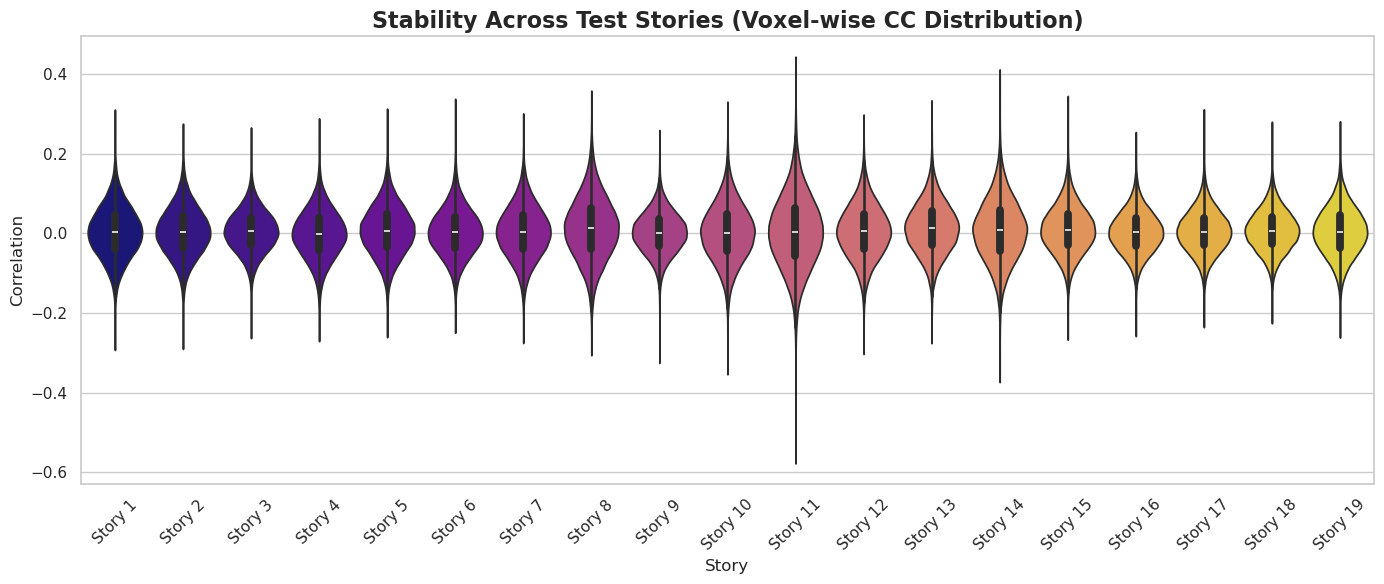

In [33]:
# ----- Visualization -----
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.cm import get_cmap

all_ccs = []
story_labels = []

for i, ccs_story in enumerate(ccs_per_story):
    all_ccs.extend(ccs_story)
    story_labels.extend([f"Story {i+1}"] * len(ccs_story))

df = pd.DataFrame({
    'Correlation': all_ccs,
    'Story': story_labels
    
})

num_stories = len(ccs_per_story)
cmap = get_cmap("plasma")  # You could also try "plasma", "coolwarm", "turbo", etc.
colors = [cmap(i / num_stories) for i in range(num_stories)]
story_names = [f"Story {i+1}" for i in range(num_stories)]
palette = dict(zip(story_names, colors))

plt.figure(figsize=(14, 6))
sns.violinplot(
    x='Story',
    y='Correlation',
    hue='Story',
    data=df,
    inner="box",
    palette=palette,
    legend=False  
)
plt.title("Stability Across Test Stories (Voxel-wise CC Distribution)", fontsize=16, weight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../results/cc_violin_plot_stability.png", dpi=300)
plt.show()
